**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution. Please read all the instructions in each notebook carefully.**  

# Exercise 3: Deep Learning Practices

In this exercise, you will familiarize yourself with various deep learning practices, including hyper-parameter tuning, regularization, and optimization techniques. You will apply these techniques within the context of a binary classification task designed to classify a given audio file as either speech or music. Please refer to the "ex3_instructions.pdf" file for a complete description of the problem and the applied techniques.

Code Template

To complete this assignment, you will progress through four different stages (tasks):

**Task 1. Basic model architecture, training, and testing loops (5 points)**

**Task 2. Fine-tuning practices (5 points)**

**Task 3. Optimization practices (5 points)**

**Task 4. Regularization practices (5 points)**

### **Deliverables:**

Please submit the completed notebooks below, along with all the requested trained models (.pth) for the corresponding subtasks.

* ex3_train_NN.ipynb
* 'base_model.pth'
* 'relu_model.pth'
* 'lr_model.pth'
* 'shuffle_model.pth'
* 'bs_model.pth'
* 'SGD_model.pth'
* 'normalized_model.pth'
* 'pooled_model.pth'

### **Data**

The dataset used for this exercise consists of a collection of audio .wav files, each with a duration of 5 seconds. You can find and download the data from the Moodle page of the course (Exercise 3). The dataset is provided as a ~150 MB ZIP file on Moodle. Please download the data and extract it into the same folder as the exercise files, naming the folder "dataset_ex3." The "dataset_ex3" folder includes "speech_wav" and "music_wav" folders, each containing audio files for speech and music, respectively.

*Note:* Your dataset path should point to the "dataset_ex3" folder, which contains the "speech" and "music" sub-folders. Be mindful of any extra folder levels that may be created when extracting the "dataset_ex3.zip" file.

After downloading the data and setting up the folders, you are ready to begin the exercise tasks. Let's get started!

## Task 1: Basic Model Design and Training (5 Points)

In this task, you will design and train a basic model for a speech versus music audio classification task. The model takes an audio signal as input and outputs a class label predicting whether the audio signal is speech or music. This exercise uses a convolutional neural network model.

Your task is to design the basic block of the neural model, write a training loop function to train the model for several epochs, and implement a validation function to test the model's performance on the validation set.

### Summary of Tasks for This Stage

**Task 1.1: Design the model architecture** (2 points)

**Task 1.2 & Task 1.3: Complete the training and validation loops** (2 points)

**Successful run of the submitted 'base_model.pth'** (1 point)

### Deliverables from this task:

* 'base_model.pth'

**Important**: Always use deep copy if you want to make your own config dictionary in the code. The exercise has already separate config placeholder for each task but you if you want to test with different config then make sure to use deep copy instead of direct initialization to another variable

In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model.

In [2]:
# Do not delete this cell

Import all necessary libraries.

In [3]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchaudio
import glob
import os
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import copy

import warnings
warnings.filterwarnings("ignore")

# Set random seeds for all libraries
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Select the device

In [4]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Add the data path

In [5]:
path = "dataset_ex3" # you can change the path if you want to store the dataset somewhere else.

In [6]:
# Do not delete this cell

The cell below defines a function for preparing a list of audio file paths from specified directories. It reads .wav files for each class (music and speech), shuffles the data, and splits it into training and validation sets based on the given validation split ratio.

In [7]:
class DataGenerator(Dataset):
    def __init__(self, mode):
        super(DataGenerator, self).__init__()
        self.dataset_path = path

        self.duration_per_file_in_s = 5 # crop the input audios to 5 seconds
        self.sampling_rate=22050
        self.samples_per_file = int(self.duration_per_file_in_s * self.sampling_rate)

        self.music_files = glob.glob(os.path.join(path, 'music_wav', '*.wav'))
        self.speech_files = glob.glob(os.path.join(path, 'speech_wav', '*.wav'))

        # Splitting files for train and test
        music_split_idx = int(0.7 * len(self.music_files))
        speech_split_idx = int(0.7 * len(self.speech_files))

        if mode == 'train':
            self.music_files = self.music_files[:music_split_idx]
            self.speech_files = self.speech_files[:speech_split_idx]
        elif mode == 'test':
            self.music_files = self.music_files[music_split_idx:]
            self.speech_files = self.speech_files[speech_split_idx:]

        # Combine all files for indexing
        self.files = self.music_files + self.speech_files
        self.labels = [0]*len(self.music_files) + [1]*len(self.speech_files)

    def __getitem__(self, item):

        file_path = self.files[item]
        label = self.labels[item]

        audio_data, sr = torchaudio.load(file_path)  # Returns a tensor with shape [channels, samples]

        # Resample if the sample rate is not 22050
        if sr !=  self.sampling_rate:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq= self.sampling_rate)
            audio_data = resample_transform(audio_data)

        if audio_data.size(0) > 1:  # Check if more than 1 channel
            audio_data = torch.mean(audio_data, dim=0, keepdim=True)

        if audio_data.size(1) > self.samples_per_file:
            audio_data = audio_data[:, :self.samples_per_file]  # Truncate
        else:
            pad_length = self.samples_per_file - audio_data.size(1)
            audio_data = torch.nn.functional.pad(audio_data, (0, pad_length))  # Pad at the end


        return audio_data, label

    def __len__(self):
        return len(self.files)

### Task 1.1: Model Architecture

In this task, you will design a **configurable convolutional neural network** and implement the model class based on the given instructions.  

In the **`MyModel`** template below, which is designed to define the model class, fill in the blanks to complete the architecture according to the provided configuration dictionary.  

The **`BasicBlock`** class serves as a fundamental building block for constructing convolutional networks. Each block consists of:  
- A convolutional layer (`Conv1d`)  
- An optional batch normalization layer  
- A non-linear activation function (`ReLU` or `Tanh`)  
- An optional dropout layer  

At the end of the network, you will include a **Global Average Pooling** layer, a **Flatten** layer, and an **Output Activation (Sigmoid)** layer.  

You are also given a configuration dictionary (`base_config`) that defines model hyperparameters, such as the number of blocks, channels, and layer properties:

```python
base_config = {
    'nb_basic_blocks': int,
    'conv_channels': list,
    'kernel_size': int,
    'stride': int,
    'non_linearity': str,
    'use_batchnorm': bool,
    'use_dropout': bool,
    'batch_size': int,
    'shuffle': bool,
    'optimizer_type': str,
    'learning_rate': float,
    'apply_pooling': bool
}
```
**Hint:**  
You will need to use a **loop** to create multiple `BasicBlocks` dynamically and append it into layers.  
Use `nn.ModuleList()` to store these blocks so that PyTorch registers them as part of the model.

<div style="text-align: center;">
    <figure>
        <img src="neural_network_model.jpg" alt="Model Architecture" style="width:900px; height:auto;"/>
    </figure>
</div>

useful links:
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html
* https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html

In [8]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, non_linearity, apply_batchnorm, apply_dropout):
        super().__init__()

        self.apply_batchnorm = apply_batchnorm
        self.apply_dropout= apply_dropout

        self.conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size, stride=stride)

        if apply_batchnorm:
            self.bn = nn.BatchNorm1d(out_channels)

        if non_linearity == "ReLU":
            self.activation_fn = nn.ReLU()
        elif non_linearity == "Tanh":
            self.activation_fn = nn.Tanh()

        if apply_dropout:
            self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv_layer(x)
        if self.apply_batchnorm:
            x = self.bn(x)
        x = self.activation_fn(x)

        if self.apply_dropout:
            x=self.dropout(x)
        return x


class MyModel(nn.Module):
    def __init__(self, nb_basic_blocks, conv_channels, kernel_size, stride, non_linearity, apply_batchnorm, apply_dropout, apply_pooling):
        super().__init__()
        self.apply_pooling = apply_pooling

        self.layers = nn.ModuleList()

        # your code here for initializing layers
        # ---------------------------------------------------------------------
        # In this task, you will design a flexible CNN model using the BasicBlock
        # defined above. Each BasicBlock may include:
        #   - Conv1d layer
        #   - Optional BatchNorm1d
        #   - Activation (ReLU or Tanh)
        #   - Optional Dropout
        #
        # Follow the steps below to build the model:
        #
        # 1. nn.ModuleList() is initialized and stored in `self.layers`.
        #
        # 2. Use a loop to create the specified number of BasicBlocks:
        #       - For the first block, set in_channels = 1
        #       - For the remaining blocks, set in_channels = conv_channels[i-1]
        #       - Set out_channels = conv_channels[i]
        #       - Pass kernel_size, stride, non_linearity, apply_batchnorm,
        #         and apply_dropout as parameters to BasicBlock.
        #       - Append each BasicBlock to `self.layers`.
        #
        # 3. If apply_pooling = True:
        #       - After each BasicBlock in the loop iteration (except the last one),
        #         append a MaxPool1d layer to `self.layers`
        #         with the same kernel_size and stride.
        #
        # 4. Once all layers are added, wrap them using nn.Sequential:
        #       self.feature_extractor = nn.Sequential(*self.layers)
        #
        # 5. Add the remaining layers:
        #       - A Global Average Pooling layer (AdaptiveAvgPool1d)
        #       - A Flatten layer
        #       - If apply_pooling = True, also include a Linear (fc) layer
        #         that maps the last channel size to 1.

        # YOUR CODE HERE
        for i in range(nb_basic_blocks):
            in_channels = 1 if i == 0 else conv_channels[i - 1]
            out_channels = conv_channels[i]
            block = BasicBlock(
                in_channels, out_channels, kernel_size, stride,
                non_linearity, apply_batchnorm, apply_dropout
            )
            self.layers.append(block)
            if apply_pooling and i != nb_basic_blocks - 1:
                self.layers.append(
                    nn.MaxPool1d(kernel_size=kernel_size, stride=stride)
                )

        self.feature_extractor = nn.Sequential(*self.layers)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        if apply_pooling:
            self.fc = nn.Linear(conv_channels[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # your code here for the forward pass
        # ---------------------------------------------------------------------
        # 1. Pass the input through the feature extractor (self.feature_extractor),
        #    which consists of multiple BasicBlocks and optional pooling layers.
        #
        # 2. Apply the global average pooling layer to reduce the spatial dimension.
        #
        # 3. Flatten the pooled output to a vector using the flatten layer.
        #
        # 4. If apply_pooling = True, pass the output through the fully connected layer.
        #
        # 5. Finally, apply the Sigmoid activation to obtain the final output.
        # ---------------------------------------------------------------------
        #
        # Hint:
        # The order should always be:
        # feature_extractor → global_avg_pool → flatten → (fc) → sigmoid

        # YOUR CODE HERE
        x = self.feature_extractor(x)
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        if self.apply_pooling:
            x = self.fc(x)
        x = self.sigmoid(x)
        return x

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

### Task 1.2: Define Loss Function and Optimizer

In this task, you will define a helper function named **`loss_and_optimizer`** that initializes both the **loss function** and the **optimizer** for your model training.

The function should accept the following parameters:
- **`model`** – the neural network whose parameters need to be optimized  
- **`optimizer_type`** – a string specifying the optimizer to use (e.g., `'Adam'` or `'SGD'`)  
- **`learning_rate`** – a floating-point value specifying the optimizer’s learning rate  


In [9]:
def loss_and_optimizer(model, optimizer_type, learning_rate):

    # your code here
    # 1. Define the loss function as Binary Cross-Entropy Loss.
    # 2. Initialize the optimizer based on optimizer_type:
    #    - If 'Adam': use Adam optimizer.
    #    - If 'SGD': use SGD optimizer.
    # 3. Return both the criterion and optimizer.
    # YOUR CODE HERE
    criterion = nn.BCELoss()
    if optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")
    return criterion, optimizer

### Train and Validate Base Model

In this task you are required to complete the python dictionary for the neural network configuration. You need to fill the value for the following keys

* conv_channels = 3
  - First channel has 1 input layer and 32 output layers
  - Second channel has 32 input layers and 32 output layers
  - Third channel has 32 input layers and 1 output layer
  **Remember**: The `conv_channels` key in base_config is a list that holds the the input and output channel layers as parameters for your implementation in **MyModel** class
* optimizer_type = Adam,
* learning_rate = 0.0001

In [10]:
base_config = {
    'nb_basic_blocks': 3,
    'conv_channels': None,
    'kernel_size': 11,
    'stride': 5,
    'non_linearity': 'Tanh',
    'use_batchnorm': False,
    'use_dropout': False,
    'batch_size': 2,
    'shuffle': False,
    'optimizer_type': None,
    'learning_rate': None,
    'apply_pooling': False
}

# your code here
# update the base_config dictionary and replace None with instructions provided in the above section
# YOUR CODE HERE
base_config['conv_channels'] = [32, 32, 1]
base_config['optimizer_type'] = 'Adam'
base_config['learning_rate'] = 0.0001

Run the cell below to verify the correctness of your solution for the model architecture.

In [11]:
# Visible tests here

base_test_config = copy.deepcopy(base_config)

all_tests_successful = True
model = MyModel(base_test_config["nb_basic_blocks"], base_test_config["conv_channels"], base_test_config["kernel_size"],
                base_test_config["stride"], base_test_config["non_linearity"], base_test_config["use_batchnorm"],
                base_test_config["use_dropout"], base_test_config["apply_pooling"]).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)
dummy_output = model(dummy_input)

# Test the number of Conv1d layers
conv1d_count = sum(1 for layer in model.modules() if isinstance(layer, nn.Conv1d))
if conv1d_count != 3:
    all_tests_successful = False
    feedback_txt.append(f"Task 1.2, Visible test: Expected 3 Conv1d layers, got {conv1d_count}.")
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

# Check the output shape
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 1.2, Visible test: Expected output shape {expected_shape}, but got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 12033
if num_params != expected_num_parameters:
    all_tests_successful = False
    feedback_txt.append(f"Task 1.2, Visible test: Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")


The model has 12033 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Task 1.3: Training and Validation Loops

In this task, you will complete the training and validation loops by filling in the blanks according to the provided instructions. The training loop iterates over the dataset to train the model, while the validation loop evaluates the model's performance on a separate validation dataset. The validation loop is called within the training loop to assess the model's accuracy and loss after each training epoch.

In [12]:
def training_loop(nb_epochs, model, optimizer, loss_fn, train_dataloader, test_dataloader, verbose=True):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(1, nb_epochs + 1):
        start = time.time()
        train_loss, correct_predictions = 0., 0.
        num_samples = 0
        for i, (input_batch, target_batch) in enumerate(train_dataloader):
            # your code here for minibatch training
            # 1. call batch data and labels and set them to the correct device
            # 2. make the prediction on the data
            # 3. calculate loss
            # 4. set optimizer to zero grad
            # 5. do backward pass
            # 6. move the optimizer one step forward
            # YOUR CODE HERE
            input_batch, target_batch = input_batch.to(device), target_batch.to(device).float()
            predictions = model(input_batch).squeeze()
            loss_train = loss_fn(predictions, target_batch)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            # accumulate correct prediction
            correct_predictions += ((predictions.detach() >= 0.5).int() == target_batch.int()).sum().item() # number of correct predictions
            train_loss += loss_train.item()

        average_train_loss = train_loss/(i+1)
        average_train_accuracy = correct_predictions/len(train_dataloader.dataset)

        test_loss, test_accuracy = testing_loop(model, loss_fn, test_dataloader)

        train_losses.append(average_train_loss)
        val_losses.append(test_loss)
        train_accuracies.append(average_train_accuracy)
        val_accuracies.append(test_accuracy)

        end = time.time()
        epoch_time = round(end - start, 2)
        if verbose:
            print(f'Epoch {epoch}, train_loss {average_train_loss:.2f}, train_accuracy: {average_train_accuracy:.4f},',
                  f'test_loss {test_loss:.2f}, test_accuracy: {test_accuracy:.4f}, time = {epoch_time}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
def testing_loop(model, loss_fn, test_dataloader):
    model.eval()
    with torch.no_grad():
        total_loss, correct_predictions = 0., 0.
        for i, (input_batch, target_batch) in enumerate(test_dataloader):
            # your code here for minibatch validation
            # 1. set input_batch, target_batch to correct device
            # 2. make the prediction on input_batch
            # 3. calculate loss and add it to previous loss
            # 4. obtain predicted class labels from predictions
            # YOUR CODE HERE
            input_batch, target_batch = input_batch.to(device), target_batch.to(device).float()
            predictions = model(input_batch).squeeze()
            loss = loss_fn(predictions, target_batch)
            total_loss += loss.item()
            correct_predictions += ((predictions.detach() >= 0.5).int() == target_batch.int()).sum().item()

    # Average for all batches
    average_loss = total_loss / (i + 1)  # Use i + 1 for the total number of batches
    average_accuracy = correct_predictions / len(test_dataloader.dataset)

    return average_loss, average_accuracy

In [14]:
def plot_loss_accuracy(train_losses, val_losses, train_acc, val_acc, nb_epochs):
    epochs = range(1, nb_epochs + 1)
    best_val_acc = max(val_acc)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ---- Loss plot ----
    ax1.plot(epochs, train_losses, label='Train', color='tab:blue')
    ax1.plot(epochs, val_losses, label='Validation', color='tab:orange')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # ---- Accuracy plot ----
    ax2.plot(epochs, train_acc, label='Train', color='tab:blue')
    ax2.plot(epochs, val_acc, label='Validation', color='tab:orange')
    ax2.set_title(f'Accuracy (Best: {best_val_acc:.2f})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Run the below cell to check the correctness of your solution for the training loop.

In [15]:
# This cell tests the training code
all_tests_successful = True

model = MyModel(base_test_config["nb_basic_blocks"], base_test_config["conv_channels"], base_test_config["kernel_size"],
                base_test_config["stride"], base_test_config["non_linearity"], base_test_config["use_batchnorm"],
                base_test_config["use_dropout"], base_test_config["apply_pooling"]).to(device)
dummy_optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
dummy_loss_fn = nn.BCELoss().to(device)

# Create TensorDataset and DataLoader
dummy_inputs = torch.rand(2, 1, 22000).to(device)
dummy_labels = torch.randint(0, 2, (2,)).to(device)

dummy_dataset = torch.utils.data.TensorDataset(dummy_inputs, dummy_labels)
dummy_dl_train = torch.utils.data.DataLoader(dummy_dataset, batch_size=2)
dummy_dl_val = torch.utils.data.DataLoader(dummy_dataset, batch_size=8)

from unittest.mock import patch, MagicMock

with patch('torch.Tensor.backward') as mock_backward, patch.object(dummy_optim, 'step') as mock_step:
    training_loop(
        nb_epochs=1,
        model=model,
        optimizer=dummy_optim,
        loss_fn=dummy_loss_fn,
        train_dataloader=dummy_dl_train,
        test_dataloader=dummy_dl_val,
        verbose=False
    )

    if mock_backward.called:   # check if .backward() was called
        pass
    else:
        all_tests_successful = False
        feedback_txt.append(f"Task 1.3, Visible test: You forgot to calculate the gradients.")
        raise AssertionError("You forgot to calculate the gradients.")

    if mock_step.called: # check if .step() is used
        pass
    else:
        all_tests_successful = False
        feedback_txt.append(f"Task 1.3, Visible test: You forgot to update the weights.")
        raise AssertionError("You forgot to update the weights.")

if all_tests_successful:
    success_str = 'Good job! you can now proceed to train your model.'
    print(f"\033[92m{success_str}\033[0m")

Good job! you can now proceed to train your model.


In [16]:
def train_and_test_your_model(config, model_name, save_model):

    train_dataset = DataGenerator(mode='train')
    test_dataset = DataGenerator(mode='test')

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=config['shuffle'])
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=config['shuffle'])

    model = MyModel(config['nb_basic_blocks'], config['conv_channels'], config['kernel_size'], config['stride'],
                    config['non_linearity'], config['use_batchnorm'], config['use_dropout'], config['apply_pooling'])
    loss_fn, optimizer = loss_and_optimizer(model, config['optimizer_type'], config['learning_rate'])

    model = model.to(device)
    loss_fn=loss_fn.to(device)

    nb_epochs = 100

    if not skip_training:
        train_losses, val_losses, train_acc, val_acc = training_loop(nb_epochs, model, optimizer, loss_fn, train_loader, test_loader)
        if save_model:
            torch.save(model.state_dict(), f'{model_name}.pth')
            print("Your trained model is saved successfully!")

        plot_loss_accuracy(train_losses, val_losses, train_acc, val_acc, nb_epochs)
        results = {
            "metrics": {
              "train_losses": train_losses,
              "validation_losses": val_losses,
              "training_accuracy": train_acc,
              "validation_accuracy": val_acc
            },
            "test_loader": test_loader,
            "loss_fn": loss_fn

        }
        return results
    else:
        model.load_state_dict(torch.load(f'{model_name}.pth', map_location=device))
        print("Loaded weights from your saved model successfully!")

### Train the Model

We will refer to this model as the "base_model." The code will save the model. You are required to submit the trained "basic_model.pth"

Epoch 1, train_loss 0.75, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.31
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.15
Epoch 3, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 3.22
Epoch 4, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.91
Epoch 5, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.92
Epoch 6, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.9
Epoch 7, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.91
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.94
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.71
Epoch 10, train_loss 0.70, train_accuracy: 0.3977, test_loss 0.69, test_accuracy: 0.5000, ti

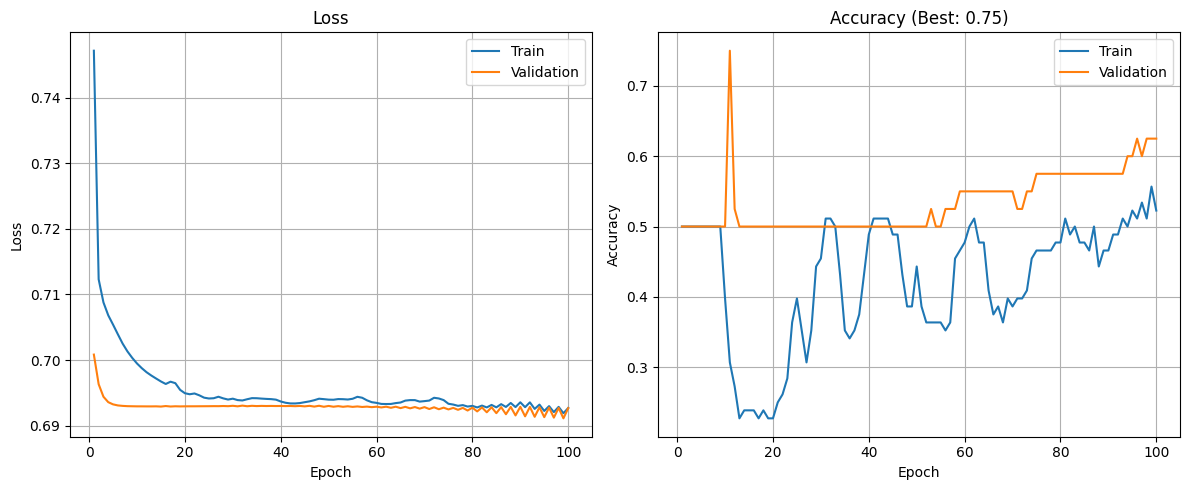

In [17]:
results = train_and_test_your_model(base_config, 'base_model', True)

Run the below cell to check correctness of your solution for the training and validation performance.

In [18]:
all_tests_successful = True
if not skip_training:
    try:
        # Test 1: Ensure training accuracy is within the correct range
        max_tacc = max(results['metrics']["training_accuracy"])
        if not (0.4 <= max_tacc <= 1):
            all_tests_successful = False
            feedback_txt.append(f"Task 1.3, Visible test: Training accuracy {max_tacc} is out of the expected range [0.4, 1].")
            raise AssertionError(f"Training accuracy {max_tacc} is out of the expected range [0.4, 1].")

        # Test 2: Ensure accuracy is within the correct range
        max_vacc = max(
            results['metrics']["validation_accuracy"])
        if not (0.4 <= max_vacc <= 1):
            all_tests_successful = False
            feedback_txt.append(f"Task 1.3, Visible test: Validation accuracy {max_vacc} is out of the expected range [0.4, 1].")
            raise AssertionError(f"Validation accuracy {max_vacc} is out of the expected range [0.4, 1].")

        if all_tests_successful:
            print(f"\033[92mAll visible tests for training and validation accuracy passed successfully!\033[0m")

    except AssertionError as e:
        feedback_txt.append(f"Task 1.3, Visible test failed: {e}")
        print(f"\033[91mTest failed: {e}\033[0m")

else:
    print("This visible test is applicable only when `skip_training` is set to `False`.")

All visible tests for training and validation accuracy passed successfully!


In [ ]:
# Do not delete this cell

## Task 2: Hyperparameter Tuning (5 Points)

In this task, you will enhance your model’s performance through targeted modifications to the architecture. The main objectives include optimizing performance on the training dataset. The goal is to implement various changes and observe how they affect the overall performance of the model in terms of training and validation results, the smoothness and stability of the training curves, the number of trainable parameters, and the training time.

### Summary of Tasks for This Stage


**Task 2.1: Increase Convolution Channels** (1 point)

    Goal: Modify the model to increase the number of convolution channels to 128 across three layers.

**Task 2.2: Add One Convolution Layer** (1 point)

    Goal: Add an additional convolution layer to the model, creating four layers with 32 intermediate channels.

**Task 2.3: Adjust Kernel Sizes (Smaller)** (1 point)

    Goal: Modify the kernel sizes to be smaller than those used in the base model.

**Task 2.4: Adjust Kernel Sizes (Larger)** (1 point)

    Goal: Modify the kernel sizes to be larger than those used in the base model.

**Task 2.5: Change Non-linearities (ReLU)** (1 point)

    Goal: Replace the current activation functions with ReLU.

### Deliverables from this task:

* 'relu_model.pth'

### Task 2.1. Increase Convolution Channels

Use the base model from Task 1, increasing the convolutional channels from 32 to 128. Fill in the blanks in the cell below as instructed in the code.

Epoch 1, train_loss 0.86, train_accuracy: 0.4773, test_loss 0.81, test_accuracy: 0.5000, time = 2.52
Epoch 2, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.78, test_accuracy: 0.5000, time = 3.12
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.77, test_accuracy: 0.5000, time = 2.48
Epoch 4, train_loss 0.82, train_accuracy: 0.5000, test_loss 0.77, test_accuracy: 0.5000, time = 2.44
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.75, test_accuracy: 0.5000, time = 2.46
Epoch 6, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.73, test_accuracy: 0.5000, time = 2.48
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 3.09
Epoch 8, train_loss 0.83, train_accuracy: 0.5000, test_loss 0.73, test_accuracy: 0.5000, time = 2.49
Epoch 9, train_loss 0.79, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 2.46
Epoch 10, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.71, test_accuracy: 0.5000, t

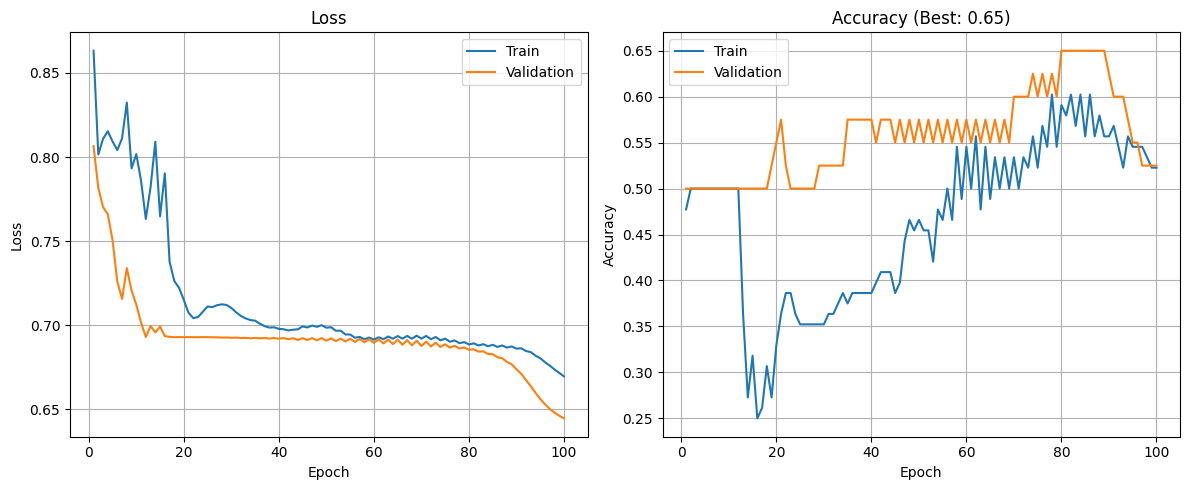

In [19]:
increased_channel_model_config = copy.deepcopy(base_config)

# YOUR CODE HERE
increased_channel_model_config['conv_channels'] = [128, 128, 1]

results = train_and_test_your_model(increased_channel_model_config, '128_channel_model', False)

In [20]:
# Visible tests here
all_tests_successful = True
model = MyModel(increased_channel_model_config['nb_basic_blocks'], increased_channel_model_config["conv_channels"],
                increased_channel_model_config["kernel_size"], increased_channel_model_config["stride"],
                increased_channel_model_config["non_linearity"], increased_channel_model_config["use_batchnorm"],
                increased_channel_model_config["use_dropout"], increased_channel_model_config["apply_pooling"]).to(device)

dummy_input = torch.randn(1, 1, 22000).to(device)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
if conv1d_count != 3:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.1, Visible test: Expected 3 Conv1d layers, got {conv1d_count}.")
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [128, 128, 1]  # Expected output channels for the three layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        feedback_txt.append(f"Task 2.1, Visible test: Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")

# Check the output shape
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.1, Visible test: Expected output shape {expected_shape}, but got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 183297
if num_params != expected_num_parameters:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.1, Visible test: Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 183297 trainable parameters.
Good job! All visible tests passed! You can proceed further.


In [21]:
# Visible tests for checking the performance of the trained model
all_tests_successful = True
if not skip_training:
    try:

        # Test 1: Ensure training accuracy is within the correct range
        max_tacc = max(results['metrics']["training_accuracy"])
        if not (0.5 <= max_tacc <= 1):
            all_tests_successful = False
            feedback_txt.append(f"Task 2.1, Visible test: Training accuracy {max_tacc} is out of the expected range [0.5, 1].")
            raise AssertionError(f"Training accuracy {max_tacc} is out of the expected range [0.5, 1].")

        # Test 2: Ensure accuracy is within the correct range
        max_vacc = max(results['metrics']["validation_accuracy"])
        if not (0.5 <= max_vacc <= 1):
            all_tests_successful = False
            feedback_txt.append(f"Task 2.1, Visible test: Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")
            raise AssertionError(f"Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")

        if all_tests_successful:
            print(f"\033[92mAll visible tests for training and validation accuracy passed successfully!\033[0m")

    except AssertionError as e:
        feedback_txt.append(f"Task 2.1, Visible test: {e}")
        print(f"\033[91mTest failed: {e}\033[0m")

else:
    print("This visible test is applicable only when `skip_training` is set to `False`.")

All visible tests for training and validation accuracy passed successfully!


### Task 2.2: Add One Convolution Layer

Next, use the base model from Task 1 (32 channels), adding one extra the convolutional layers to have 4 convolutional layers with 32 intermediate filters (channels). Fill in the blanks in the cell below as instructed in the code.

**Hint**: Add one more layer in the `conv_channel` key for the `increased_basic_block_config`

Epoch 1, train_loss 0.75, train_accuracy: 0.4091, test_loss 0.70, test_accuracy: 0.5000, time = 1.97
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.45
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.29
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.98
Epoch 5, train_loss 0.70, train_accuracy: 0.3523, test_loss 0.69, test_accuracy: 0.5000, time = 1.93
Epoch 6, train_loss 0.70, train_accuracy: 0.2841, test_loss 0.69, test_accuracy: 0.5000, time = 1.93
Epoch 7, train_loss 0.70, train_accuracy: 0.2727, test_loss 0.69, test_accuracy: 0.5000, time = 1.93
Epoch 8, train_loss 0.70, train_accuracy: 0.2955, test_loss 0.69, test_accuracy: 0.5000, time = 2.58
Epoch 9, train_loss 0.70, train_accuracy: 0.2841, test_loss 0.69, test_accuracy: 0.5000, time = 2.13
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, t

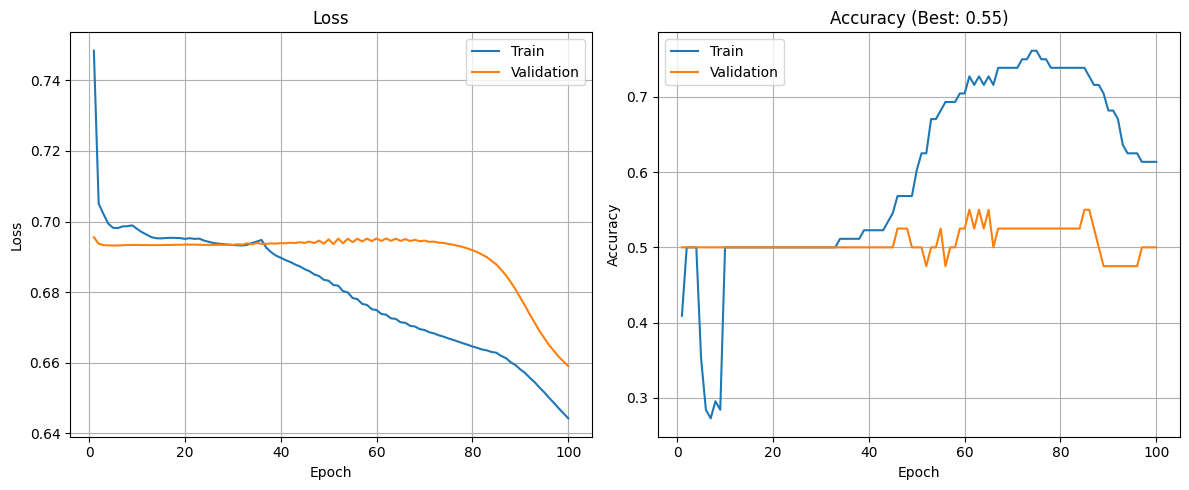

In [22]:
increased_basic_block_config = copy.deepcopy(base_config)

# YOUR CODE HERE
increased_basic_block_config['nb_basic_blocks'] = 4
increased_basic_block_config['conv_channels'] = [32, 32, 32, 1]

results = train_and_test_your_model(increased_basic_block_config, '4_basic_blocks', False)

Run the cell below to verify the correctness of your solution for the model architecture.

In [23]:
# Visible tests here
all_tests_successful = True
model = MyModel(increased_basic_block_config['nb_basic_blocks'], increased_basic_block_config["conv_channels"],
                increased_basic_block_config["kernel_size"], increased_basic_block_config["stride"],
                increased_basic_block_config["non_linearity"], increased_basic_block_config["use_batchnorm"],
                increased_basic_block_config["use_dropout"], increased_basic_block_config["apply_pooling"]).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
if conv1d_count != 4:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.2, Visible test: Expected 3 Conv1d layers, got {conv1d_count}.")
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [32, 32, 32, 1]  # Expected output channels for the three layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        feedback_txt.append(f"Task 2.2, Visible test: Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")

# Check the output shape
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.2, Visible test: Expected output shape {expected_shape}, but got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Check the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 23329
if num_params != expected_num_parameters:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.2, Visible test: Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 23329 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Task 2.3: Adjust Kernel Sizes (Smaller)
In this task, you will modify the base model by using smaller kernel sizes for the convolutional layers. Set the kernel size to 7 and the stride to 3 and keeping the same convolutional channels as your initial implemetation. Fill in the blanks in the code cell below as directed to apply these changes.

Epoch 1, train_loss 0.73, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.0
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.46
Epoch 3, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.19
Epoch 4, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.95
Epoch 5, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.93
Epoch 6, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.92
Epoch 7, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.94
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.62
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.02
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, ti

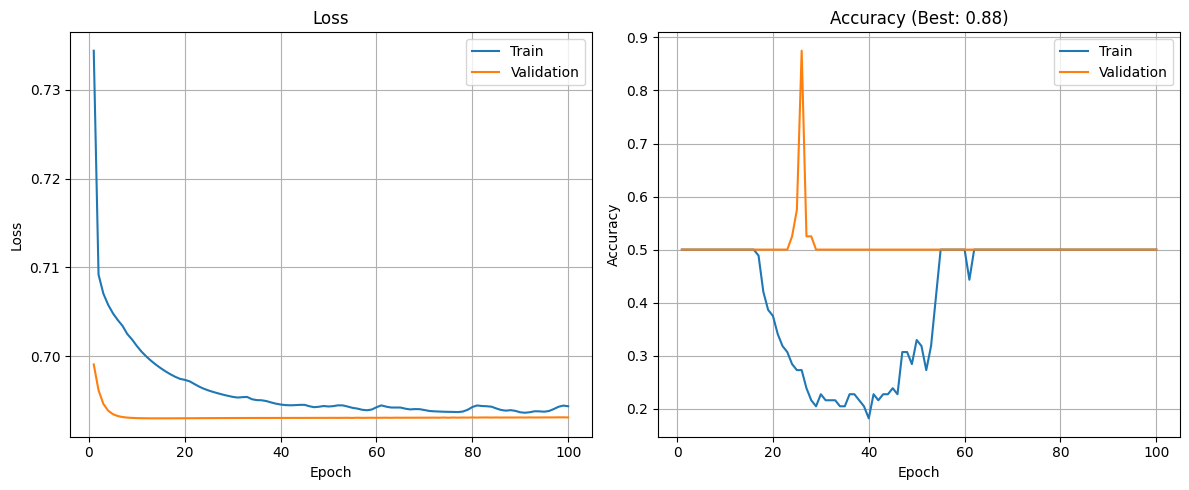

In [24]:
reduced_kernel_size_and_stride_config = copy.deepcopy(base_config)

# YOUR CODE HERE
reduced_kernel_size_and_stride_config['kernel_size'] = 7
reduced_kernel_size_and_stride_config['stride'] = 3

results = train_and_test_your_model(reduced_kernel_size_and_stride_config, 'reduced_kernel_size_and_stride', False)

In [25]:
# Visible tests here
all_tests_successful = True

model = MyModel(reduced_kernel_size_and_stride_config['nb_basic_blocks'], reduced_kernel_size_and_stride_config["conv_channels"],
                reduced_kernel_size_and_stride_config['kernel_size'], reduced_kernel_size_and_stride_config['stride'],
                reduced_kernel_size_and_stride_config['non_linearity'], reduced_kernel_size_and_stride_config['use_batchnorm'],
                reduced_kernel_size_and_stride_config['use_dropout'], reduced_kernel_size_and_stride_config['apply_pooling']).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
if conv1d_count != 3:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.3, Expected 3 Conv1d layers, got {conv1d_count}.")
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [32, 32, 1]  # Expected output channels for the three layers
expected_kernels = [7, 7, 7]

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        feedback_txt.append(f"Task 2.3, Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
    # Check the kernel size
    if layer.kernel_size[0] != expected_kernels[i]:
        all_tests_successful = False
        feedback_txt.append(f"Task 2.3, Conv1d layer {i + 1} does not have the expected kernel size of {expected_kernels[i]}. It has {layer.kernel_size}.")
        raise AssertionError(f"Conv1d layer {i + 1} does not have the expected kernel size of {expected_kernels[i]}. It has {layer.kernel_size}.")
# Check the output shape
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.3, Expected output shape {expected_shape}, but got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 7681
if num_params != expected_num_parameters:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.3, Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 7681 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Task 2.4: Adjust Kernel Sizes (Larger)
In this step, return to the base model config and modify the kernel sizes of the convolutional layers to be larger. Use kernels of size 22 and a stride of 11. Complete the cell below by filling in the blanks as specified in the code.

Epoch 1, train_loss 0.80, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 2.23
Epoch 2, train_loss 0.73, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.45
Epoch 3, train_loss 0.72, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.95
Epoch 4, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.0
Epoch 5, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.91
Epoch 6, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.94
Epoch 7, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.43
Epoch 8, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.26
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.91
Epoch 10, train_loss 0.70, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.6000, ti

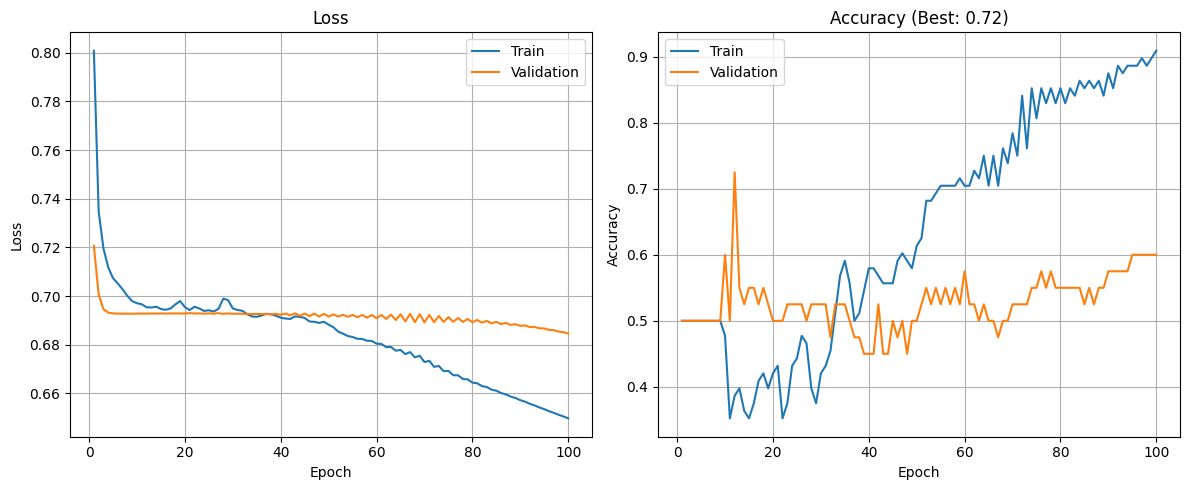

In [26]:
increased_kernel_size_and_stride_config = copy.deepcopy(base_config)

# YOUR CODE HERE
increased_kernel_size_and_stride_config['kernel_size'] = 22
increased_kernel_size_and_stride_config['stride'] = 11

results =  train_and_test_your_model(increased_kernel_size_and_stride_config, 'increased_kernel_size_and_stride', False)

Run the cell below to verify the correctness of your solution for the model architecture.

In [27]:
# Visible tests here
all_tests_successful = True
model = MyModel(increased_kernel_size_and_stride_config["nb_basic_blocks"], increased_kernel_size_and_stride_config["conv_channels"],
                increased_kernel_size_and_stride_config['kernel_size'], increased_kernel_size_and_stride_config['stride'],
                increased_kernel_size_and_stride_config["non_linearity"], increased_kernel_size_and_stride_config["use_batchnorm"],
                increased_kernel_size_and_stride_config["use_dropout"], increased_kernel_size_and_stride_config["apply_pooling"]).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)
expected_kernels = [22, 22, 22]


# Test the number of Conv1d layers
if conv1d_count != 3:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.4, Expected 3 Conv1d layers, got {conv1d_count}.")
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [32, 32, 1]  # Expected output channels for the three layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        feedback_txt.append(f"Task 2.4, Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
    # Check the kernel size
    if layer.kernel_size[0] != expected_kernels[i]:
        all_tests_successful = False
        feedback_txt.append(f"Task 2.4, Conv1d layer {i + 1} does not have the expected kernel size of {expected_kernels[i]}. It has {layer.kernel_size}.")
        raise AssertionError(f"Conv1d layer {i + 1} does not have the expected kernel size of {expected_kernels[i]}. It has {layer.kernel_size}.")

# Check the output shape
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.4, Expected output shape {expected_shape}, but got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 24001
if num_params != expected_num_parameters:
    all_tests_successful = False
    feedback_txt.append(f"Task 2.4, Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 24001 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Task 2.5: Change Non-linearities
For this task, return to the base model and explore the impact of different non-linear activation functions on the model's performance.

Re-create the base model by filling in the blanks in the cell below as instructed. Try using "ReLU" as an alternative activation function to see how that affect training and validation results.

Save the model as **relu_model.pth** and submit it to Moodle along with your other files.

Epoch 1, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.0
Epoch 2, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.93
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.93
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.01
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.71
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.96
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.95
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.96
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.95
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, ti

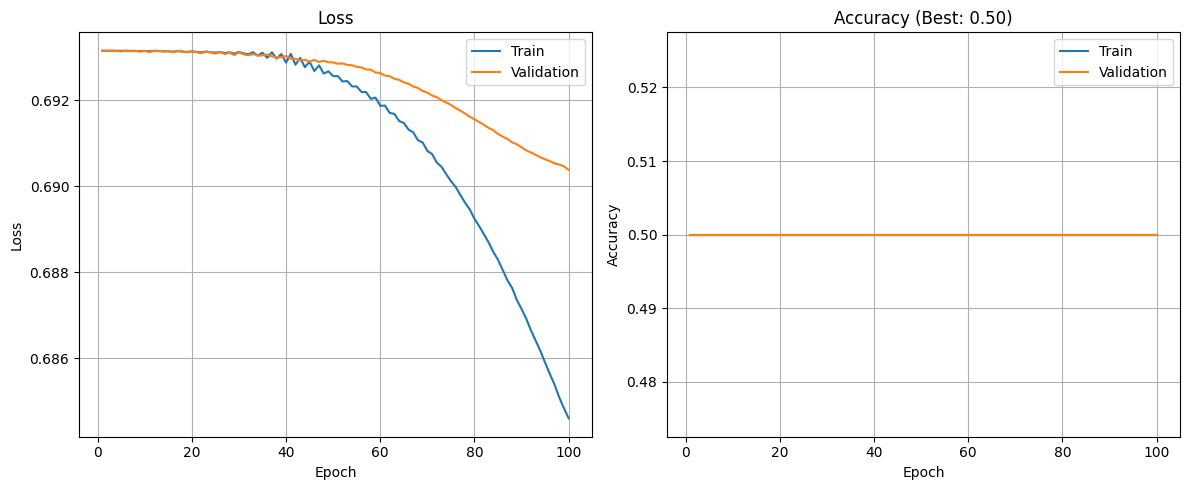

In [28]:
relu_model_config = copy.deepcopy(base_config)

# YOUR CODE HERE
relu_model_config['non_linearity'] = "ReLU"

results = train_and_test_your_model(relu_model_config, 'relu_model', True)

Run the cell below to verify the correctness of your solution for the model architecture.

In [29]:
# Visible tests for checking the performance of the trained model
all_tests_successful = True
model = MyModel(relu_model_config['nb_basic_blocks'], relu_model_config["conv_channels"], relu_model_config['kernel_size'],
                relu_model_config['stride'], relu_model_config['non_linearity'], relu_model_config['use_batchnorm'],
                relu_model_config['use_dropout'], relu_model_config['apply_pooling']).to(device)
if not skip_training:
    try:
        # Test 0: Ensure non-linearity is ReLU
        basic_blocks = [layer for layer in model.modules() if isinstance(layer, BasicBlock)]
        for i, block in enumerate(basic_blocks):
            if not isinstance(block.activation_fn, nn.ReLU):
                all_tests_successful = False
                feedback_txt.append(f"Task 2.5, BasicBlock {i + 1} does not use ReLU as the activation function.")
                raise AssertionError(f"BasicBlock {i + 1} does not use ReLU as the activation function.")

        # Test 1: Ensure training accuracy is within the correct range
        max_tacc = max(results['metrics']['training_accuracy'])
        if not (0.5 <= max_tacc <= 1):
            all_tests_successful = False
            feedback_txt.append(f"Task 2.5, Training accuracy {max_tacc} is out of the expected range [0.5, 1].")
            raise AssertionError(f"Training accuracy {max_tacc} is out of the expected range [0.5, 1].")

        # Test 2: Ensure accuracy is within the correct range
        max_vacc = max(results['metrics']['validation_accuracy'])
        if not (0.5 <= max_vacc <= 1):
            all_tests_successful = False
            feedback_txt.append(f"Task 2.5, Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")
            raise AssertionError(f"Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")

        if all_tests_successful:
            print(f"\033[92mAll visible tests for training and validation accuracy passed successfully!\033[0m")

    except AssertionError as e:
        feedback_txt.append(f"Task 2.5, {e}")
        print(f"\033[91mTest failed: {e}\033[0m")

else:
    print("This visible test is applicable only when `skip_training` is set to `False`.")

All visible tests for training and validation accuracy passed successfully!


In [ ]:
# Do not delete this cell

## Task 3: Optimization Practices (5 Points)

In this task, you will practice optimization techniques by experimenting with different optimizers, learning rates, and batch sizes. The main objectives include observing the performance and computational costs related to training time. Additionally, pay attention to the training curves: in deep learning, smoother training and validation curves are generally desirable, as they often indicate stable learning and consistent generalization.

You can achieve smoother training curves by adjusting the learning rate and increasing the batch size. Another important factor to consider is batch variability through data shuffling. While data shuffling can enhance training, very high learning rates, combined with shuffling, can negatively impact the smoothness and stability of the training process, potentially leading to unstable learning.

By completing this task, you will gain insights into how different optimization choices affect the training dynamics of your model.


### Summary of Tasks for This Stage


**Task 3.1: Experiment with Adam optimizer with different learning rates** (1 point)

    Goal: Increase the learning rate in each test to find the optimal learning rate.

**Task 3.2: Experiment with Adam optimizer with different learning rates and shuffling data in each batch** (1 point)

    Goal: Allow the data to be shuffled in each batch, increase the learning rate, and observe its effect.

**Task 3.3: Experiment with Adam optimizer and different batch sizes** (1 point)

    Goal: Observe the effect of batch sizes on training stability and efficiency.

**Task 3.4: Experiment with SGD optimizer with different learning rates and shuffling data in each batch** (1 point)

    Goal: Observe the effect of data variability and learning rate in the SGD optimizer.

**Task 3.5: Experiment with SGD optimizer and batch normalization layers** (1 point)

    Goal: Observe the effect of batch normalization layers in the SGD optimizer.
    

### Deliverables from this task:

* 'lr_model.pth'
* 'shuffle_model.pth'
* 'bs_model.pth'
* 'SGD_model.pth'

### Task 3.1: Experiment with Adam optimizer with different learning rates

Use the settings applied in Task 1 for the base model:

- `batch_size = 8`
- `optimizer = "Adam"`

Gradually increase the learning rate from 0.0001 (used in the base model) to observe its effect and find the optimal learning rate for this setting. In particular, test the following learning rates:

- `lr = [0.0001, 0.001, 0.01, 0.1]`

Save the best-performing model as **'lr_model.pth'** and submit it to Moodle along with your other files.

**Goal**: Identify how different learning rates impact model performance, stability, and training efficiency for the current setup.



Epoch 1, train_loss 0.86, train_accuracy: 0.4091, test_loss 0.75, test_accuracy: 0.5000, time = 1.81
Epoch 2, train_loss 0.74, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 1.83
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 1.8
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.02
Epoch 5, train_loss 0.70, train_accuracy: 0.1818, test_loss 0.69, test_accuracy: 0.5000, time = 2.43
Epoch 6, train_loss 0.70, train_accuracy: 0.1364, test_loss 0.69, test_accuracy: 0.5000, time = 1.83
Epoch 7, train_loss 0.70, train_accuracy: 0.1364, test_loss 0.69, test_accuracy: 0.5000, time = 1.8
Epoch 8, train_loss 0.70, train_accuracy: 0.1364, test_loss 0.69, test_accuracy: 0.5000, time = 1.8
Epoch 9, train_loss 0.70, train_accuracy: 0.1136, test_loss 0.69, test_accuracy: 0.5000, time = 1.8
Epoch 10, train_loss 0.70, train_accuracy: 0.1250, test_loss 0.69, test_accuracy: 0.5000, time 

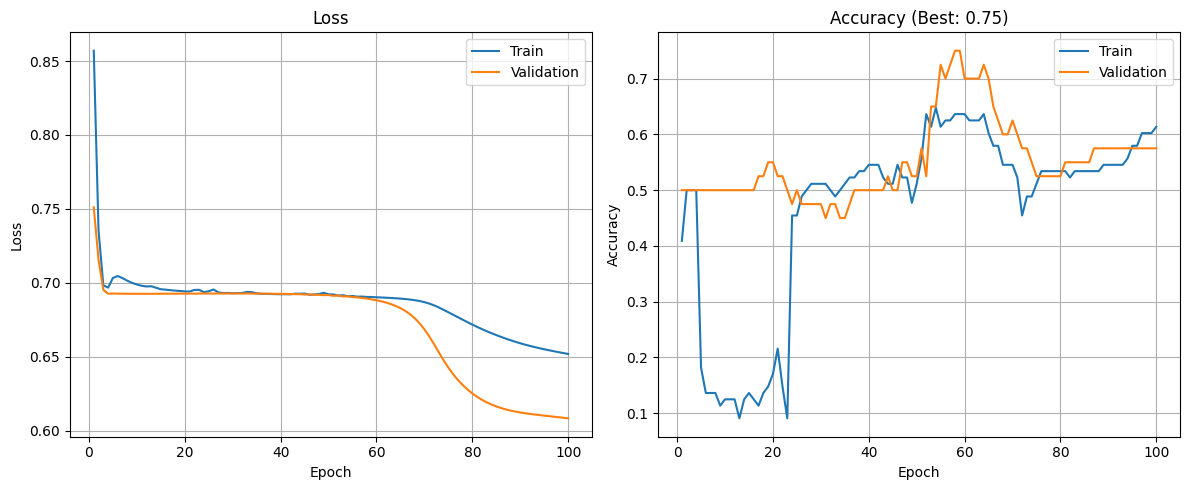

In [31]:
optimizer_lr_config = copy.deepcopy(base_config)

# YOUR CODE HERE
optimizer_lr_config['optimizer_type'] = 'Adam'
optimizer_lr_config['batch_size'] = 8
optimizer_lr_config['learning_rate'] = 0.001

results = train_and_test_your_model(optimizer_lr_config, 'lr_model', True)

In [32]:
# Do not delete this cell

### Task 3.2: Experiment with Adam optimizer with different learning rates and shuffling data in each batch

Repeat the experiments from Task 3.1, this time with data shuffling enabled to increase batch variability (by setting `shuffle=True`). Test the following learning rates:

- `lr = [0.0001, 0.001, 0.01, 0.1]`

Save the best-performing model as **'shuffle_model.pth'** and submit it to Moodle along with your other files.

**Goal**: Identify how different learning rates impact model performance and stability in the presence of data variability.

Epoch 1, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 2.09
Epoch 2, train_loss 0.70, train_accuracy: 0.4659, test_loss 0.69, test_accuracy: 0.5000, time = 2.35
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.82
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.87
Epoch 5, train_loss 0.70, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 1.86
Epoch 6, train_loss 0.69, train_accuracy: 0.4205, test_loss 0.69, test_accuracy: 0.5000, time = 1.89
Epoch 7, train_loss 0.69, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 1.92
Epoch 8, train_loss 0.69, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 2.56
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.82
Epoch 10, train_loss 0.69, train_accuracy: 0.5341, test_loss 0.69, test_accuracy: 0.7750, t

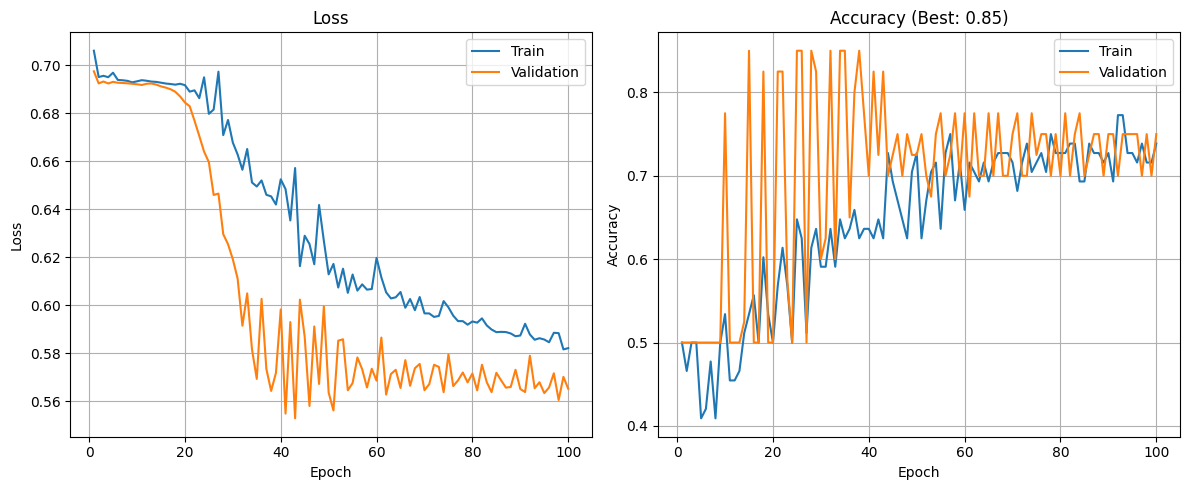

In [33]:
shuffle_model_config = copy.deepcopy(base_config)

# YOUR CODE HERE
shuffle_model_config['optimizer_type'] = 'Adam'
shuffle_model_config['batch_size'] = 8
shuffle_model_config['shuffle'] = True
shuffle_model_config['learning_rate'] = 0.001

results = train_and_test_your_model(shuffle_model_config, 'shuffle_model', True)

In [34]:
# Do not delete this cell

### Task 3.3: Experiment with Adam optimizer and different batch sizes

Now, set the optimizer to Adam with `lr = 0.001` and disable data shuffling (`shuffle=False`). Try different batch sizes as specified below:

- `bs = [4, 8, 16, 32]`

Save the best-performing model as **'bs_model.pth'** and submit it to Moodle along with your other files.

**Optional:** You may repeat the experiments above with data shuffling enabled (`shuffle=True`) to observe the impact of batch size when data variability is increased.

Epoch 1, train_loss 0.80, train_accuracy: 0.3182, test_loss 0.74, test_accuracy: 0.5000, time = 1.82
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.72, test_accuracy: 0.5000, time = 2.62
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 1.84
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.83
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.82
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.82
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 1.81
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 2.53
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 1.9
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, ti

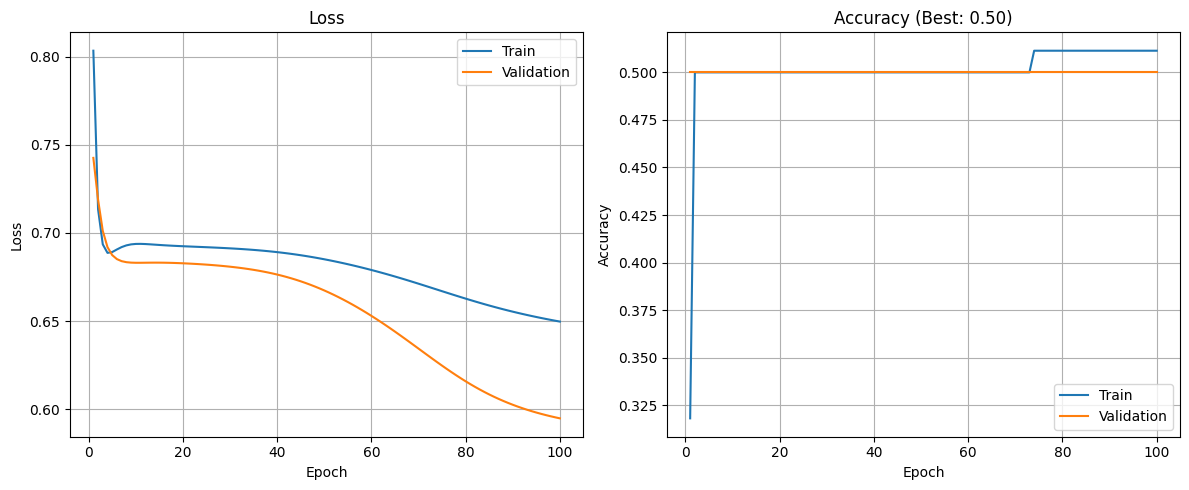

In [35]:
batchsize_model_config = copy.deepcopy(base_config)

# YOUR CODE HERE
batchsize_model_config['optimizer_type'] = 'Adam'
batchsize_model_config['learning_rate'] = 0.001
batchsize_model_config['shuffle'] = False
batchsize_model_config['batch_size'] = 16

results = train_and_test_your_model(batchsize_model_config, 'bs_model', True)

In [36]:
# Do not delete this cell

### Task 3.4: Experiment with SGD optimizer with different learning rates and shuffling data in each batch

Repeat the experiments from Task 3.2, keeping data shuffling enabled, and change the optimizer to SGD. Test the following learning rates:

- `lr = [0.0001, 0.001, 0.01, 0.1]`

Save the best-performing model as **'SGD_model.pth'** and submit it to Moodle along with your other files.

**Goal**: Observe the different behaviors of Adam and SGD optimizers, and examine how the choice of optimizer impacts the selection and effect of learning rate on model performance.

Epoch 1, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.69, test_accuracy: 0.5000, time = 2.17
Epoch 2, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.31
Epoch 3, train_loss 0.69, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 1.86
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.8
Epoch 5, train_loss 0.69, train_accuracy: 0.4318, test_loss 0.69, test_accuracy: 0.5000, time = 1.82
Epoch 6, train_loss 0.69, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 1.78
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.85
Epoch 8, train_loss 0.69, train_accuracy: 0.4773, test_loss 0.69, test_accuracy: 0.5000, time = 2.58
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 1.79
Epoch 10, train_loss 0.69, train_accuracy: 0.3864, test_loss 0.69, test_accuracy: 0.5000, ti

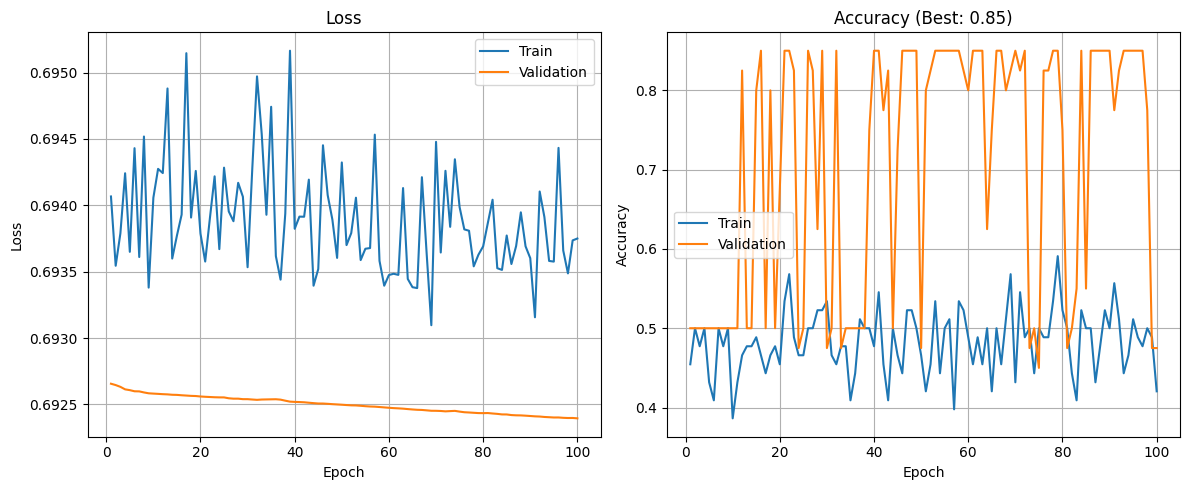

In [37]:
optimizer_model_config = copy.deepcopy(base_config)

# YOUR CODE HERE
optimizer_model_config['optimizer_type'] = 'SGD'
optimizer_model_config['shuffle'] = True
optimizer_model_config['batch_size'] = 8
# Set your tested learning rate here, e.g.:
optimizer_model_config['learning_rate'] = 0.01

results = train_and_test_your_model(optimizer_model_config, 'SGD_model', True)

In [38]:
# Do not delete this cell

### Task 3.5: Experiment with SGD optimizer and normalization layers

Next, test the effect of batch normalization layers on the SGD optimizer using the following setup for training:

- Batch data shuffling disabled (`shuffle=False`)
- `learning_rate = 0.01`
- `batch_size = 16`
- `optimizer_type = SGD`

Use the base model, then add a batch normalization layer within each convolutional block. Place this layer directly after each convolution layer and before applying the non-linearity function, as indicated in the code.

`Hint: set use_batchnorm to true`

**useful link**: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

Epoch 1, train_loss 0.70, train_accuracy: 0.3977, test_loss 0.71, test_accuracy: 0.5000, time = 1.83
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.70, test_accuracy: 0.5000, time = 1.84
Epoch 3, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.1500, time = 1.84
Epoch 4, train_loss 0.71, train_accuracy: 0.3523, test_loss 0.69, test_accuracy: 0.5000, time = 1.83
Epoch 5, train_loss 0.70, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 2.43
Epoch 6, train_loss 0.70, train_accuracy: 0.2273, test_loss 0.69, test_accuracy: 0.5000, time = 2.02
Epoch 7, train_loss 0.70, train_accuracy: 0.4091, test_loss 0.69, test_accuracy: 0.5000, time = 1.82
Epoch 8, train_loss 0.70, train_accuracy: 0.3182, test_loss 0.69, test_accuracy: 0.5000, time = 1.8
Epoch 9, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 1.78
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, ti

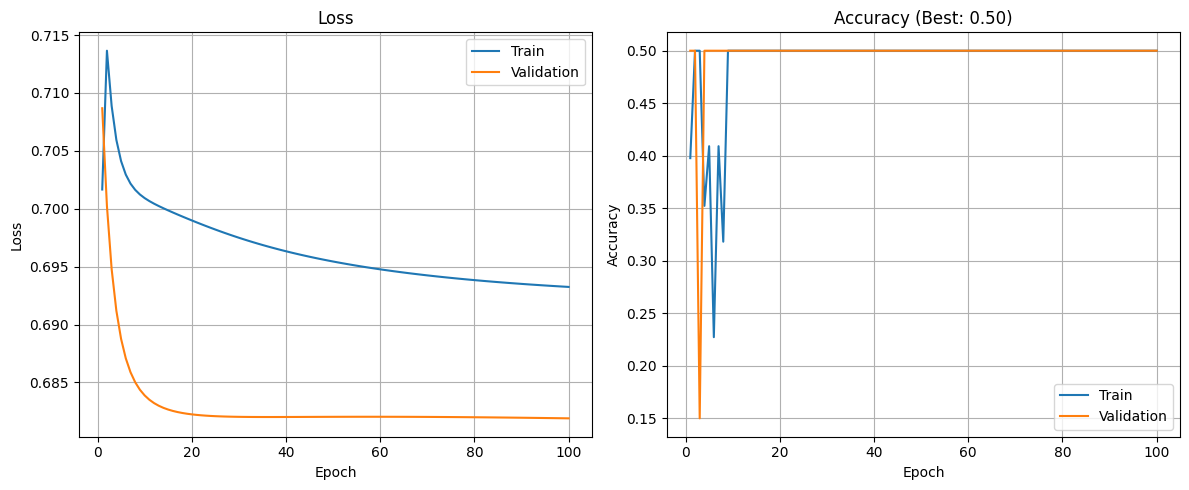

In [41]:
normalization_model_config = copy.deepcopy(base_config)

# YOUR CODE HERE
normalization_model_config['optimizer_type'] = 'SGD'
normalization_model_config['shuffle'] = False
normalization_model_config['batch_size'] = 16
normalization_model_config['learning_rate'] = 0.01
normalization_model_config['use_batchnorm'] = True

results = train_and_test_your_model(normalization_model_config, 'normalization_model', False)

In [42]:
# Visible tests here
all_tests_successful = True
model = MyModel(normalization_model_config['nb_basic_blocks'], normalization_model_config["conv_channels"], normalization_model_config['kernel_size'],
                normalization_model_config['stride'], normalization_model_config['non_linearity'], normalization_model_config['use_batchnorm'],
                normalization_model_config['use_dropout'], normalization_model_config['apply_pooling']).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)

# Dictionary to hold the execution order of each BasicBlock's layers
layer_execution_order = {}
# Function to capture forward pass order of layers within each BasicBlock
def track_execution_order(module, input, output, name):
    layer_types = []
    for sub_module in module.children():  # Iterate through layers within BasicBlock
        layer_types.append(type(sub_module))
    layer_execution_order[name] = layer_types

# Register hooks on each BasicBlock to capture layer order in forward pass
for name, module in model.named_modules():
    if isinstance(module, BasicBlock):
        module.register_forward_hook(lambda mod, inp, out, n=name: track_execution_order(mod, inp, out, n))

# Run the model forward pass to trigger hooks
dummy_output = model(dummy_input)

# Define the expected order of layer types for BasicBlock
expected_order = [nn.Conv1d, nn.BatchNorm1d, nn.Tanh]

# Check if each BasicBlock followed the expected order
for name, order in layer_execution_order.items():
    # Modify expected_order based on the chosen activation in model
    current_expected_order = expected_order[:]
    activation_fn_type = type(model.layers[0].activation_fn)  # Get the actual activation type
    current_expected_order[-1] = activation_fn_type

    if order != current_expected_order:
        all_tests_successful = False
        feedback_txt.append(f"Task 3.5, Visible test: {name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]}."
                           f"but got {[cls.__name__ for cls in order]}.")
        raise AssertionError(
            f"{name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]} "
            f"but got {[cls.__name__ for cls in order]}."
        )

# Check output shape and range for LogSoftmax
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 3.5, Visible test: Expected output shape {expected_shape}, got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, got {dummy_output.shape}.")

# Final success message if all tests pass
if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


## Task 4: Regularization Practices (5 Points)

In Task 2 you have tried differnt hyperparameter tuning techniques to increase the performance of the model on the training set. In this task, you will practice regularization techniques to help the model to generalize to unseen data, i.e., to increase the performance on the validation set. You are asked to start with a model that achieves a good performance on the training set compared to the base model. However, the number of trainable parameters in this model is large which leads to over-fitting as observed in the training and validation curves. Here we try different techniques to decreadse the number of trainable påarameters and to increase the model performance on validation set.


### Summary of Tasks for This Stage


**Task 4.1: Experiment with normalization layers** (1 point)

    Goal: Observe the effect of batch normalization in model generalization and training stability.

**Task 4.2: Experiment with dropout layers** (1 point)

    Goal: Observe the effect of dropout layers in model generalization.

**Task 4.3: Experiment with efficient model architecture through pooling layers** (3 point)

    Goal: Observe the effect of efficient model design through adjusting receptive field of layers.


### Deliverables from this task:

* 'normalized_model.pth'
* 'pooled_model.pth'

### Model Architecture:

Fill in the blanks as instructed in the code to design the model architecture similar to the base config model but with four convolutional blocks, where the number of filters (channels) in each convolutional layer is set to 128.

Epoch 1, train_loss 0.85, train_accuracy: 0.4773, test_loss 0.81, test_accuracy: 0.5000, time = 3.25
Epoch 2, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.51
Epoch 3, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.52
Epoch 4, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.51
Epoch 5, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.12
Epoch 6, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.67
Epoch 7, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.49
Epoch 8, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 2.51
Epoch 9, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, time = 3.57
Epoch 10, train_loss 0.81, train_accuracy: 0.5000, test_loss 0.81, test_accuracy: 0.5000, t

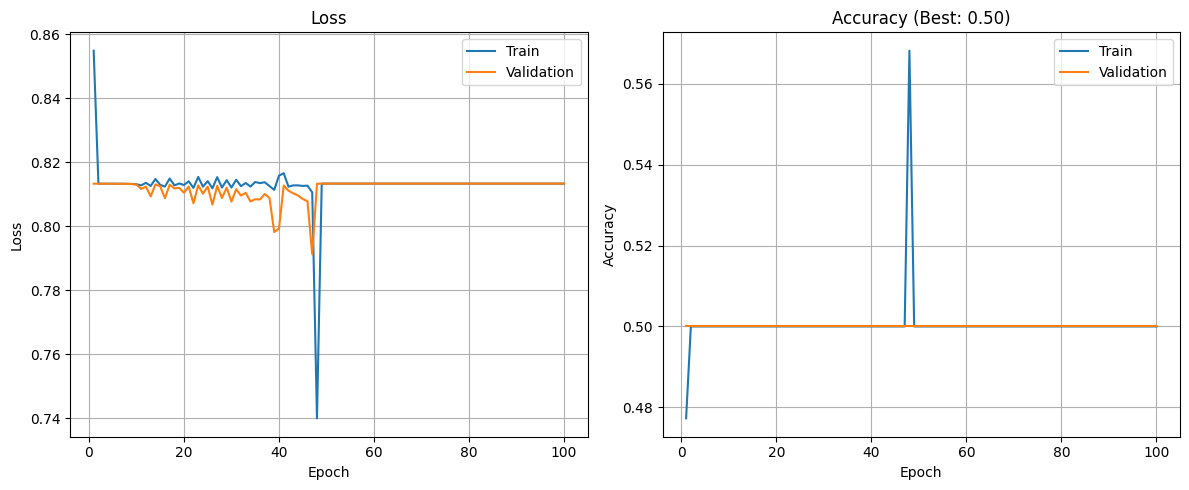

In [43]:
channel_128_config = copy.deepcopy(base_config)

# YOUR CODE HERE
channel_128_config['nb_basic_blocks'] = 4
channel_128_config['conv_channels'] = [128, 128, 128, 1]

results = train_and_test_your_model(channel_128_config, 'channel_128', False)

Run the cell below to verify the correctness of your model architecture solution.

In [44]:
# Visible tests here
all_tests_successful = True
model = MyModel(channel_128_config['nb_basic_blocks'], channel_128_config['conv_channels'], channel_128_config['kernel_size'],
                channel_128_config['stride'], channel_128_config['non_linearity'],
                channel_128_config['use_batchnorm'], channel_128_config['use_dropout'], channel_128_config['apply_pooling']).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
if conv1d_count != 4:
    all_tests_successful = False
    feedback_txt.append(f"Task 4, Visible test: Expected 3 Conv1d layers, got {conv1d_count}.")
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [128, 128, 128, 1]  # Expected output channels for the three layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        feedback_txt.append(f"Task 4, Visible test: Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")

# Check the output shape
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 4, Visible test: Expected output shape {expected_shape}, but got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 363649
if num_params != expected_num_parameters:
    all_tests_successful = False
    feedback_txt.append(f"Task 4, Visible test: Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 363649 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Task 4.1: Experiment with normalization layers

Add a batch normalization layer after the convolution layer and before applying the non-linearity function. Train the model, monitor the behavior of the training and validation curves, and observe how the normalization layer affects the validation performance.

Save the model as **'normalized_model.pth'** and submit it to Moodle along with your other files.


Epoch 1, train_loss 0.72, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.57
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 3.13
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.55
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.48
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.5
Epoch 6, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.61
Epoch 7, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 3.1
Epoch 8, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.5
Epoch 9, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.46
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time

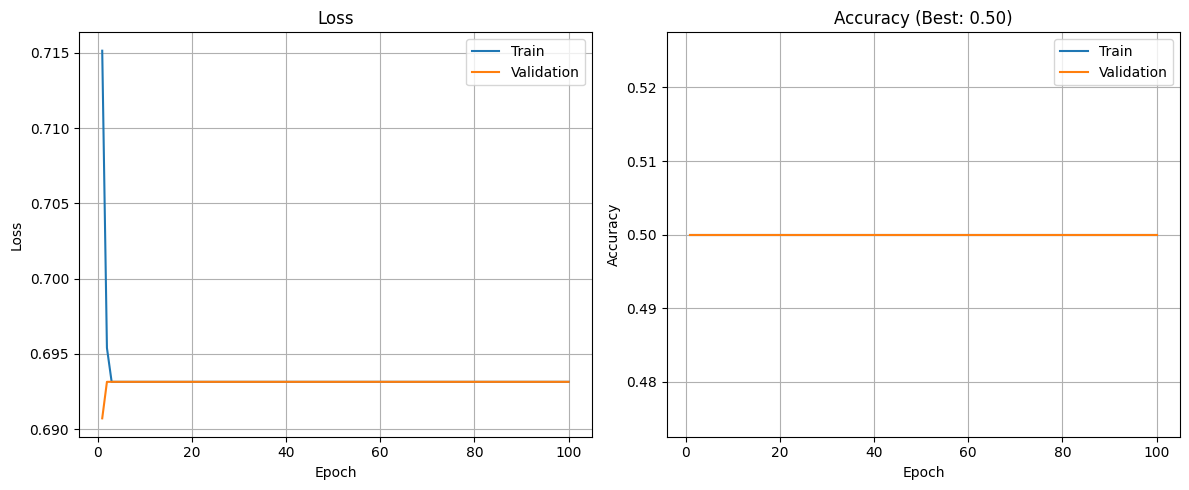

In [45]:
normalized_config = copy.deepcopy(base_config)

# YOUR CODE HERE
normalized_config['nb_basic_blocks'] = 4
normalized_config['conv_channels'] = [128, 128, 128, 1]
normalized_config['use_batchnorm'] = True
normalized_config['non_linearity'] = "ReLU"

results = train_and_test_your_model(normalized_config, 'normalized_model', True)

Run the cell below to verify the correctness of your model architecture solution.

In [46]:
# Visible tests here
all_tests_successful = True
model = MyModel(normalized_config['nb_basic_blocks'], normalized_config['conv_channels'], normalized_config['kernel_size'],
                normalized_config['stride'], "ReLU",
                normalized_config['use_batchnorm'], normalized_config['use_dropout'], normalized_config['apply_pooling']).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)

# Dictionary to hold the execution order of each BasicBlock's layers
layer_execution_order = {}
# Function to capture forward pass order of layers within each BasicBlock
def track_execution_order(module, input, output, name):
    layer_types = []
    for sub_module in module.children():  # Iterate through layers within BasicBlock
        layer_types.append(type(sub_module))
    layer_execution_order[name] = layer_types

# Register hooks on each BasicBlock to capture layer order in forward pass
for name, module in model.named_modules():
    if isinstance(module, BasicBlock):
        module.register_forward_hook(lambda mod, inp, out, n=name: track_execution_order(mod, inp, out, n))

# Run the model forward pass to trigger hooks
dummy_output = model(dummy_input)

# Define the expected order of layer types for BasicBlock
expected_order = [nn.Conv1d, nn.BatchNorm1d, nn.ReLU]

# Check if each BasicBlock followed the expected order
for name, order in layer_execution_order.items():
    # Modify expected_order based on the chosen activation in model
    current_expected_order = expected_order[:]
    activation_fn_type = type(model.layers[0].activation_fn)  # Get the actual activation type
    current_expected_order[-1] = activation_fn_type

    if order != current_expected_order:
        all_tests_successful = False
        feedback_txt.append(f"Task 4.1, Visible test: {name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]} "
                            f"but got {[cls.__name__ for cls in order]}.")
        raise AssertionError(
            f"{name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]} "
            f"but got {[cls.__name__ for cls in order]}."
        )

# Check output shape and range for LogSoftmax
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 4.1, Visible test: Expected output shape {expected_shape}, got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, got {dummy_output.shape}.")

# Final success message if all tests pass
if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


In [47]:
# Do not delete this cell

### Task 4.2: Experiment with dropout layers

Keep the normalization layers and add a dropout layer as the last layer of the convolutional block.

Train the model, monitor the behavior of the training and validation curves, and observe how the dropout layers affects the validation performance.

`Hint:` set dropout to True in your config

Epoch 1, train_loss 0.72, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.0
Epoch 2, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.0
Epoch 3, train_loss 0.68, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.5000, time = 1.97
Epoch 4, train_loss 0.68, train_accuracy: 0.5000, test_loss 0.67, test_accuracy: 0.5000, time = 1.96
Epoch 5, train_loss 0.68, train_accuracy: 0.5000, test_loss 0.67, test_accuracy: 0.5000, time = 2.38
Epoch 6, train_loss 0.68, train_accuracy: 0.5000, test_loss 0.67, test_accuracy: 0.5000, time = 2.35
Epoch 7, train_loss 0.67, train_accuracy: 0.5000, test_loss 0.66, test_accuracy: 0.5000, time = 1.98
Epoch 8, train_loss 0.67, train_accuracy: 0.5000, test_loss 0.66, test_accuracy: 0.5000, time = 1.95
Epoch 9, train_loss 0.67, train_accuracy: 0.5000, test_loss 0.65, test_accuracy: 0.5000, time = 1.95
Epoch 10, train_loss 0.66, train_accuracy: 0.5000, test_loss 0.65, test_accuracy: 0.5000, tim

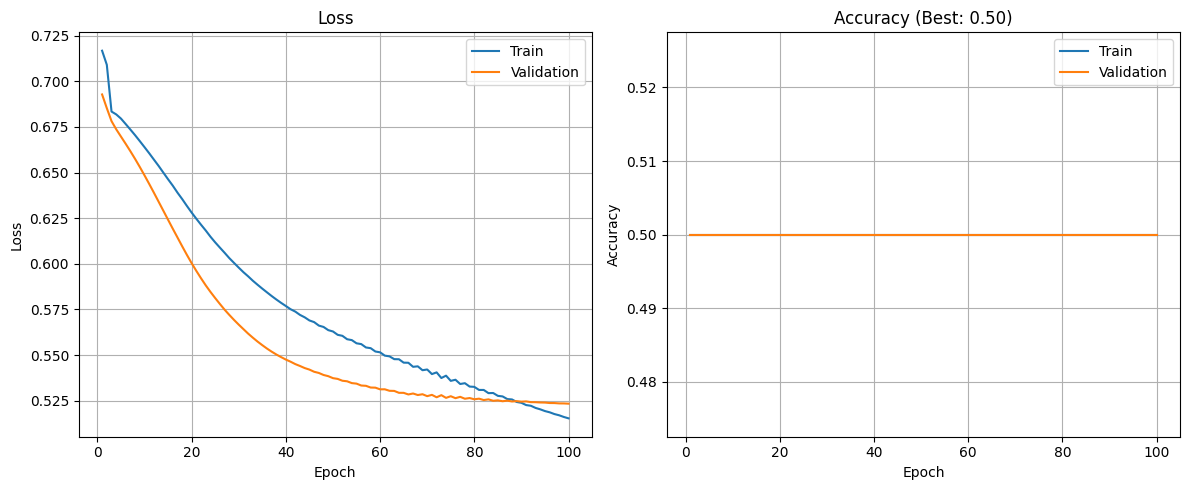

In [55]:
dropout_config = copy.deepcopy(base_config)

# YOUR CODE HERE
dropout_config['use_batchnorm'] = True
dropout_config['use_dropout'] = True
dropout_config['non_linearity'] = "ReLU"

results = train_and_test_your_model(dropout_config, 'dropout_model', False)

Run the cell below to verify the correctness of your solution for the model architecture.

In [56]:
feedback_txt = []

In [57]:
# Visible tests here
all_tests_successful = True
model = MyModel(dropout_config['nb_basic_blocks'], dropout_config['conv_channels'], dropout_config['kernel_size'],
                dropout_config['stride'], "ReLU",
                dropout_config['use_batchnorm'], dropout_config['use_dropout'], dropout_config['apply_pooling']).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)

# Dictionary to hold the execution order of each BasicBlock's layers
layer_execution_order = {}

# Function to capture forward pass order of layers within each BasicBlock
def track_execution_order(module, input, output, name):
    layer_types = []
    for sub_module in module.children():  # Iterate through layers within BasicBlock
        layer_types.append(type(sub_module))
    layer_execution_order[name] = layer_types

# Register hooks on each BasicBlock to capture layer order in forward pass
for name, module in model.named_modules():
    if isinstance(module, BasicBlock):
        module.register_forward_hook(lambda mod, inp, out, n=name: track_execution_order(mod, inp, out, n))

# Run the model forward pass to trigger hooks
dummy_output = model(dummy_input)

# Define the expected order of layer types for BasicBlock with Dropout
expected_order = [nn.Conv1d, nn.BatchNorm1d, nn.ReLU, nn.Dropout]

# Check if each BasicBlock followed the expected order
for name, order in layer_execution_order.items():
    # Modify expected_order based on the chosen activation in model
    current_expected_order = expected_order[:]
    activation_fn_type = type(model.layers[0].activation_fn)  # Get the actual activation type
    current_expected_order[2] = activation_fn_type  # Ensure activation function is dynamically set

    if order != current_expected_order:
        all_tests_successful = False
        feedback_txt.append(f"Task 4.2, Visible test: {name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]} "
                            f"but got {[cls.__name__ for cls in order]}.")
        raise AssertionError(
            f"{name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]} "
            f"but got {[cls.__name__ for cls in order]}."
        )

# Check output shape and range for LogSoftmax
expected_shape = (1, 1)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 4.2, Visible test: Expected output shape {expected_shape}, got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, got {dummy_output.shape}.")

# Final success message if all tests pass
if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


### Task 4.3: Experiment with efficient model architecture through pooling layers

As the final step, try to increase the model efficiency through a wiser design of the model architecture. In a deep learning model, while using a stack of convolutional blocks, it is common practice to use pooling layers between convolutional layers to decrease the dimension of the data and the resolution of deeper layers. This helps make the model lighter by reducing the number of trainable parameters and, at the same time, increases the model's performance by helping it focus on different feature types at different layers. For example, in the case of audio processing, the shallower layers can focus on finding variations in short time windows, while deeper layers can focus on detecting longer variations.

In this task, you are asked to follow the same logic and modify the model architecture using pooling layers.

Set the configuration for you config according to following:

- kernel_size set to 10
- stride set to 2
- non_linearity to ReLU
- normalization, dropout and pooling set to True
- The conv_channel will be of size 3 with the following configuration:
  - first layer: input channel: 1, output channel: 8
  - second layer: input channel: 8, output channel: 16
  - third layer: input channel: 16, output channel: 32

    `Hint`: set the conv_channel to 8,16,32

Save the trained model as **'pooled_model.pth'** and submit it to Moodle along with your other files.

Epoch 1, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.4750, time = 2.17
Epoch 2, train_loss 0.74, train_accuracy: 0.3977, test_loss 0.69, test_accuracy: 0.5000, time = 2.01
Epoch 3, train_loss 0.71, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.02
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.5000, time = 2.25
Epoch 5, train_loss 0.70, train_accuracy: 0.5000, test_loss 0.69, test_accuracy: 0.6500, time = 2.61
Epoch 6, train_loss 0.70, train_accuracy: 0.4886, test_loss 0.68, test_accuracy: 0.6750, time = 2.02
Epoch 7, train_loss 0.70, train_accuracy: 0.4545, test_loss 0.68, test_accuracy: 0.7250, time = 2.01
Epoch 8, train_loss 0.70, train_accuracy: 0.4432, test_loss 0.68, test_accuracy: 0.6750, time = 1.94
Epoch 9, train_loss 0.69, train_accuracy: 0.4545, test_loss 0.68, test_accuracy: 0.7000, time = 1.97
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, test_loss 0.68, test_accuracy: 0.7000, t

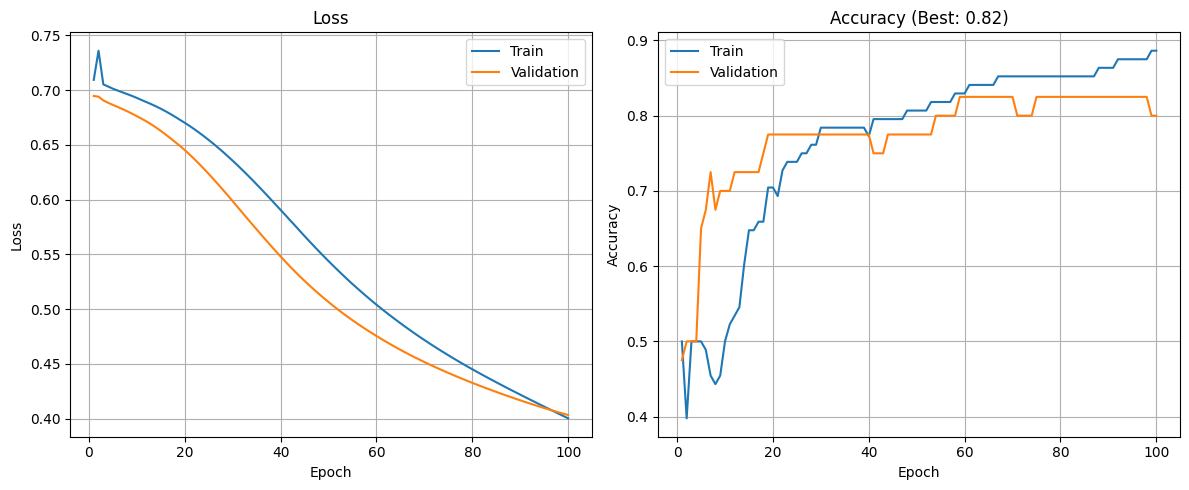

In [50]:
pooling_config = copy.deepcopy(base_config)

# YOUR CODE HERE
pooling_config['nb_basic_blocks'] = 3
pooling_config['conv_channels'] = [8, 16, 32]
pooling_config['kernel_size'] = 10
pooling_config['stride'] = 2
pooling_config['non_linearity'] = "ReLU"
pooling_config['use_batchnorm'] = True
pooling_config['use_dropout'] = True
pooling_config['apply_pooling'] = True

results = train_and_test_your_model(pooling_config, 'pooled_model', True)

In [51]:
# Visible tests here
all_tests_successful = True
model = MyModel(pooling_config['nb_basic_blocks'], pooling_config['conv_channels'], pooling_config['kernel_size'],
                pooling_config['stride'], pooling_config['non_linearity'], pooling_config['use_batchnorm'],
                pooling_config['use_dropout'], pooling_config['apply_pooling']).to(device)
dummy_input = torch.randn(1, 1, 22000).to(device)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
expected_conv_count = 3  # Number of Conv1d layers expected
if conv1d_count != expected_conv_count:
    all_tests_successful = False
    feedback_txt.append(f"Task 4.3, Visible test: Expected {expected_conv_count} Conv1d layers, got {conv1d_count}.")
    raise AssertionError(f"Expected {expected_conv_count} Conv1d layers, got {conv1d_count}.")

# Check expected output channels
expected_channels = [8, 16, 32]  # Expected output channels for the three Conv1d layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        feedback_txt.append(f"Task 4.3, Visible test: Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")

# Check the output shape
expected_shape = (1, 1)  # Expected output shape
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    feedback_txt.append(f"Task 4.3, Visible test: Expected output shape {expected_shape}, but got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Check the number of trainable parameters
def get_num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = get_num_trainable_parameters(model)
expected_num_parameters = 6681  # Expected number of trainable parameters
if num_params != expected_num_parameters:
    all_tests_successful = False
    feedback_txt.append(f"Task 4.3, Visible test: Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")


Good job! All visible tests passed! You can proceed further.


In [52]:
# Visible tests for checking the performance of the trained model
all_tests_successful = True
if not skip_training:
    try:
        # Test 1: Ensure training accuracy is within the correct range
        max_tacc = max(results['metrics']["training_accuracy"])
        if not (0.5 <= max_tacc <= 1):
            all_tests_successful = False
            feedback_txt.append(f"Task 4.3, Visible test: Training accuracy {max_tacc} is out of the expected range [0.5, 1].")
            raise AssertionError(f"Training accuracy {max_tacc} is out of the expected range [0.5, 1].")

        # Test 2: Ensure accuracy is within the correct range
        max_vacc = max(results['metrics']["training_accuracy"])
        if not (0.5 <= max_vacc <= 1):
            all_tests_successful = False
            feedback_txt.append(f"Task 4.3, Visible test: Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")
            raise AssertionError(f"Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")

        if all_tests_successful:
            print(f"\033[92mAll visible tests for training and validation accuracy passed successfully!\033[0m")

    except AssertionError as e:
        print(f"\033[91mTest failed: {e}\033[0m")

else:
    print("This visible test is applicable only when `skip_training` is set to `False`.")

All visible tests for training and validation accuracy passed successfully!


In [ ]:
# Do not delete this cell

In [ ]:
# Do not delete this cell